# TNC SSL Training debug

In [1]:
from pathlib import Path
from typing import List, Tuple

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
import yaml
import math
import functools

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Setting the random seeds so we can get the very same output as the author's code 

In [2]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
#torch.use_deterministic_algorithms(True)

## Test 1: Dataset class
We'll try to sameple the same time windows

In [3]:
class TNCDataset(Dataset):
    def __init__(
        self,
        data: np.ndarray,
        mc_sample_size: int,
        window_size: int,
        state: float = None,
        adf: bool = True,
        augmentation: int = 1  # Simple repeat the vecvor 'augmentation' times
    ):
        super().__init__()
        self.time_series = data
        self.T = data.shape[-1]
        self.window_size = window_size
        self.sliding_gap = int(window_size * 25.2)
        self.window_per_sample = (self.T - 2 * self.window_size) // self.sliding_gap
        self.mc_sample_size = mc_sample_size
        self.state = state
        self.adf = adf
        self.epsilon = None
        self.augmentation = augmentation

    def __len__(self):
        return len(self.time_series) * self.augmentation

    # @functools.cache
    def __getitem__(self, ind):
        ind = ind % len(self.time_series)       # To repeat augmentation
        t = np.random.randint(2 * self.window_size, self.T - 2 * self.window_size)
        x_t = self.time_series[ind][
            :, t - self.window_size // 2 : t + self.window_size // 2
        ]
        X_close = self._find_neighours(self.time_series[ind], t)
        X_distant = self._find_non_neighours(self.time_series[ind], t)

        if self.state is None:
            y_t = -1
        else:
            y_t = np.round(
                np.mean(
                    self.state[ind][
                        t - self.window_size // 2 : t + self.window_size // 2
                    ]
                )
            )
        return (
            x_t.astype(np.float32),
            X_close.astype(np.float32),
            X_distant.astype(np.float32),
            y_t,
        )

    def _find_neighours(self, x, t):
        T = self.time_series.shape[-1]

        # ---- Do the ADF test ----
        gap = self.window_size
        corr = []
        for w_t in range(self.window_size, 4 * self.window_size, gap):
            try:
                p_val = 0
                for f in range(x.shape[-2]):
                    p = adfuller(
                        np.array(
                            x[
                                f, max(0, t - w_t) : min(x.shape[-1], t + w_t)
                            ].reshape(
                                -1,
                            )
                        )
                    )[1]
                    p_val += 0.01 if math.isnan(p) else p
                corr.append(p_val / x.shape[-2])
            except:
                corr.append(0.6)
        self.epsilon = (
            len(corr)
            if len(np.where(np.array(corr) >= 0.01)[0]) == 0
            else (np.where(np.array(corr) >= 0.01)[0][0] + 1)
        )
        self.delta = 5 * self.epsilon * self.window_size
        # --------------------------

        ## Random from a Gaussian
        t_p = [
            int(t + np.random.randn() * self.epsilon * self.window_size)
            for _ in range(self.mc_sample_size)
        ]
        t_p = [
            max(self.window_size // 2 + 1, min(t_pp, T - self.window_size // 2))
            for t_pp in t_p
        ]
        x_p = np.stack(
            [
                x[:, t_ind - self.window_size // 2 : t_ind + self.window_size // 2]
                for t_ind in t_p
            ]
        )
        return x_p

    def _find_non_neighours(self, x, t):
        T = self.time_series.shape[-1]
        if t > T / 2:
            t_n = np.random.randint(
                self.window_size // 2,
                max((t - self.delta + 1), self.window_size // 2 + 1),
                self.mc_sample_size,
            )
        else:
            t_n = np.random.randint(
                min((t + self.delta), (T - self.window_size - 1)),
                (T - self.window_size // 2),
                self.mc_sample_size,
            )
        x_n = np.stack(
            [
                x[:, t_ind - self.window_size // 2 : t_ind + self.window_size // 2]
                for t_ind in t_n
            ]
        )

        if len(x_n) == 0:
            rand_t = np.random.randint(0, self.window_size // 5)
            if t > T / 2:
                x_n = x[:, rand_t : rand_t + self.window_size].unsqueeze(0)
            else:
                x_n = x[:, T - rand_t - self.window_size : T - rand_t].unsqueeze(0)
        return x_n

In [4]:
# Hyperparameters
encoding_size = 10
window_size = 4
augmentation = 5
batch_size = 10
mc_sample_size = 20
workers = 10

In [5]:
from sklearn.model_selection import train_test_split

data_path = Path('data/TNC/HAR_data')
x_train = np.load(data_path/'x_train.npy')
y_train = np.load(data_path/'y_train.npy')
x_test = np.load(data_path/'x_test.npy')
y_test = np.load(data_path/'y_test.npy')

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

#X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
n_train = int(0.8*len(x_train))

train_dataset = TNCDataset(x_train[:n_train], mc_sample_size=20, window_size=4, augmentation=augmentation)
validation_dataset = TNCDataset(x_train[:n_train], mc_sample_size=20, window_size=4, augmentation=augmentation)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=workers, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=workers, shuffle=True)

len(train_dataset), len(validation_dataset)

(21, 561, 281) (21, 281) (9, 561, 288) (9, 288)


(80, 80)

In [6]:
x_t, X_close, X_distant, y_t = train_dataset[29]

print(len(train_dataset)) 
print(x_t.shape, X_close.shape, X_distant.shape, y_t)
print(f'x_t[0]={x_t[0]}')
print(X_close[0])
print(X_distant[0])
print(y_t)
#x_t[0]=0.2724721

80
(561, 4) (20, 561, 4) (20, 561, 4) -1
x_t[0]=[0.25042    0.26520944 0.2842265  0.27390146]
[[ 0.3125356   0.29215354  0.27738905  0.27785668]
 [-0.05184692 -0.02228442 -0.01960972 -0.01918734]
 [-0.22958235 -0.17052555 -0.08727847 -0.09040321]
 ...
 [-0.81264085 -0.8647166  -0.8859118  -0.88107115]
 [ 0.02338346  0.03818248  0.04070062  0.04155072]
 [-0.09535573 -0.06066822 -0.04298371 -0.04844802]]
[[ 0.28725162  0.11776522  0.25119483  0.28823853]
 [-0.00342336  0.21637088 -0.04456717 -0.01830093]
 [-0.13564935  0.21102436 -0.10959529 -0.11527154]
 ...
 [-0.78148085 -0.7269532  -0.5488129  -0.553364  ]
 [ 0.2439978  -0.00132714 -0.09377017 -0.08595823]
 [-0.02253753 -0.15111849 -0.23460884 -0.23706494]]
-1


## Part 2: Testing model architecture

Next goal is to feed each model with an array of 1s and check if the encoder's and the discriminator's outputs are the same as the author's.

In [17]:
class Discriminator(torch.nn.Module):
    def __init__(self, input_size, device: str = "cpu"):
        super(Discriminator, self).__init__()
        self.input_size = input_size

        self.model = torch.nn.Sequential(
            torch.nn.Linear(2 * self.input_size, 4 * self.input_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4 * self.input_size, 1),
        ).to(device)

        # torch.nn.init.xavier_uniform_(self.model[0].weight)
        # torch.nn.init.xavier_uniform_(self.model[3].weight)

    def forward(self, x, x_tild):
        """
        Predict the probability of the two inputs belonging to the same neighbourhood.
        """
        x_all = torch.cat([x, x_tild], -1)
        p = self.model(x_all)
        return p.view((-1,))

In [18]:
class GRUEncoder(torch.nn.Module):
    def __init__(
        self,
        hidden_size: int = 100,
        in_channel: int = 561,
        encoding_size: int = 10,
        num_layers: int = 1,
        dropout: float = 0.0,
        bidirectional: bool = True,
        device: str = "cpu",
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.in_channel = in_channel
        self.num_layers = num_layers
        self.encoding_size = encoding_size
        self.bidirectional = bidirectional
        self.device = device
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_size*(int(self.bidirectional) + 1), self.encoding_size)
        ).to(self.device)
        
        self.rnn = torch.nn.GRU(
            input_size=self.in_channel,
            hidden_size=self.hidden_size,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout,
            bidirectional=bidirectional,
        ).to(device)

    def forward(self, x):
        x = x.permute(2, 0, 1) #(batch_size, user, window_size)

        past = torch.zeros(
            self.num_layers * (int(self.bidirectional) + 1),
            x.shape[1],
            self.hidden_size,
            device=self.device,
        )

        out, _ = self.rnn(x, past)  # out shape = [seq_len, batch_size, num_directions*hidden_size]
        encodings = self.nn(out[-1].squeeze(0))
        with open('out_jupyter.yaml', 'w') as f:
            yaml.dump(out.detach().cpu().numpy().tolist(), f)
            
        with open('encodings_jupyter.yaml', 'w') as f:
            yaml.dump(encodings.detach().cpu().numpy().tolist(), f)
        return encodings

In [24]:
# creating models instances
discriminator = Discriminator(input_size=encoding_size, device='cuda')
discriminator.load_state_dict(torch.load('./weights/disc_weights.pt'))
encoder = GRUEncoder(encoding_size=encoding_size, device='cuda')
checkpoint = torch.load('./ckpt_har/checkpoint_0.pth.tar')
#print(checkpoint['encoder_state_dict'])
encoder.load_state_dict(checkpoint['encoder_state_dict'])

<All keys matched successfully>

In [26]:
# checking untrained output for a single batch
# TENTAR MONTAR UMA ENTRADA PADRÃO
#x_t, x_p, x_n, _ = next(iter(train_dataloader))
device='cuda'
mc_sample = 20
batch_size, f_size, len_size = (10, 561, 4)
x_t = torch.ones(torch.Size([10, 561, 4]))
x_p = torch.ones(torch.Size([10, 20, 561, 4]))
x_n = torch.ones(torch.Size([10, 20, 561, 4]))
x_p = x_p.reshape((-1, f_size, len_size))
x_n = x_n.reshape((-1, f_size, len_size))
x_t = np.repeat(x_t, mc_sample, axis=0)
x_t, x_p, x_n = x_t.to(device), x_p.to(device), x_n.to(device)

z_t = encoder(x_t.to(device='cuda'))
z_p = encoder(x_p.to(device='cuda'))
z_n = encoder(x_n.to(device='cuda'))

dp_dummy = torch.ones(z_p.shape, device='cuda')
dn_dummy = torch.ones(z_n.shape, device='cuda')
dt_dummy = torch.ones(z_t.shape, device='cuda')

d_p = discriminator(dt_dummy, dp_dummy)
d_n = discriminator(dt_dummy, dn_dummy)

print(f'z_t={z_t[0]}')
print(f'z_p={z_p[0]}')
print(f'z_n={z_n[0]}')
print(f'd_p={d_p[0]}')
print(f'd_n={d_n[0]}')

z_t=tensor([ 0.3483,  0.0633, -0.0792, -0.4992, -0.8666,  0.2112, -1.3599, -0.8159,
         0.9400,  0.2088], device='cuda:0', grad_fn=<SelectBackward0>)
z_p=tensor([ 0.3483,  0.0633, -0.0792, -0.4992, -0.8666,  0.2112, -1.3599, -0.8159,
         0.9400,  0.2088], device='cuda:0', grad_fn=<SelectBackward0>)
z_n=tensor([ 0.3483,  0.0633, -0.0792, -0.4992, -0.8666,  0.2112, -1.3599, -0.8159,
         0.9400,  0.2088], device='cuda:0', grad_fn=<SelectBackward0>)
d_p=-0.15153206884860992
d_n=-0.14392100274562836


In [27]:
# comparing losses
w = 0.05
loss_fn = torch.nn.BCEWithLogitsLoss()
neighbors = torch.ones((len(x_p))).to('cuda')
non_neighbors = torch.zeros((len(x_n))).to('cuda')

p_loss = loss_fn(d_p, neighbors)
n_loss = loss_fn(d_n, non_neighbors)
n_loss_u = loss_fn(d_n, neighbors)
loss = (p_loss + w*n_loss_u + (1-w)*n_loss)/2

print(loss)

tensor(0.6947, device='cuda:0', grad_fn=<DivBackward0>)


In [25]:
print(discriminator.state_dict())

OrderedDict([('model.0.weight', tensor([[ 3.5324e-02,  8.8791e-02,  1.3919e-01, -6.0138e-02, -2.4341e-02,
         -1.7753e-01,  8.5222e-02,  1.8496e-01,  1.7689e-01,  3.0121e-02,
          1.0923e-01,  1.9140e-01, -9.5379e-02,  9.9869e-02,  7.1432e-02,
         -1.3445e-01, -1.8060e-01, -1.1918e-01, -6.7960e-02, -1.0374e-01],
        [-1.7809e-01,  8.1421e-04,  5.7657e-02,  1.9202e-01, -3.5919e-03,
         -1.9985e-01,  2.1701e-01,  1.1247e-01, -1.3425e-01, -1.3720e-01,
         -2.0809e-01, -8.8676e-02,  1.8977e-01, -8.1354e-02, -1.5813e-01,
          2.2205e-01,  2.6198e-02, -2.1920e-02,  1.2036e-01, -1.3019e-01],
        [ 3.2219e-02, -5.4258e-02,  2.1573e-02, -1.2166e-01, -3.0175e-02,
         -5.0496e-02,  1.4165e-01, -3.8301e-02,  2.1762e-01,  3.3953e-02,
         -1.2315e-01,  1.4320e-01,  8.7130e-03, -4.7996e-02,  1.9766e-01,
         -1.9842e-01,  5.8972e-02, -1.5090e-01,  3.2478e-02,  1.2987e-01],
        [-1.1042e-01, -1.8737e-01, -9.2159e-03, -1.2945e-01, -2.1505e-01,
   

In [12]:
print(z_t)

tensor([[ 0.3483,  0.0633, -0.0792,  ..., -0.8159,  0.9400,  0.2088],
        [ 0.3483,  0.0633, -0.0792,  ..., -0.8159,  0.9400,  0.2088],
        [ 0.3483,  0.0633, -0.0792,  ..., -0.8159,  0.9400,  0.2088],
        ...,
        [ 0.3483,  0.0633, -0.0792,  ..., -0.8159,  0.9400,  0.2088],
        [ 0.3483,  0.0633, -0.0792,  ..., -0.8159,  0.9400,  0.2088],
        [ 0.3483,  0.0633, -0.0792,  ..., -0.8159,  0.9400,  0.2088]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


## Test 3: Training

We'll analyse the training metrics along the training and check if they do match the author's.

In [9]:
class TNC(pl.LightningModule):
    def __init__(
        self,
        encoder: torch.nn.Module,
        discriminator: torch.nn.Module,
        mc_sample_size: int = 20,
        window_size: int = 4,
        w: float = 0.05,
        lr: float = 1e-3,
        weight_decay: float = 1e-5,
    ):
        super().__init__()
        self.encoder = encoder.to(self.device)
        self.discriminator = discriminator.to(self.device)
        self.mc_sample_size = mc_sample_size
        self.window_size = window_size
        self.w = w
        self.learning_rate = lr
        self.weight_decay = weight_decay
        self.loss_func = torch.nn.BCEWithLogitsLoss()
        self.training_step_losses = []
        self.train_epoch_loss = []

    def training_step(self, batch, batch_idx):
        x_t, x_p, x_n, _ = batch
        print(type(x_t))
        print(type(x_p))
        print(type(x_n))
        mc_sample = x_p.shape[1]
        batch_size, f_size, len_size = x_t.shape
        x_p = x_p.view(-1, f_size, len_size)
        x_n = x_n.view(-1, f_size, len_size)
        x_t = x_t.repeat(mc_sample, 1, 1)
        neighbors = torch.ones(len(x_p)).to(self.device)
        non_neighbors = torch.zeros(len(x_n)).to(self.device)
        x_t, x_p, x_n = x_t.to(self.device), x_p.to(self.device), x_n.to(self.device)

        z_t = self.encoder(x_t)
        z_p = self.encoder(x_p)
        z_n = self.encoder(x_n)

        d_p = self.discriminator(z_t, z_p)
        d_n = self.discriminator(z_t, z_n)

        p_loss = self.loss_func(d_p, neighbors)
        n_loss = self.loss_func(d_n, non_neighbors)
        n_loss_u = self.loss_func(d_n, neighbors)
        loss = (p_loss + self.w * n_loss_u + (1 - self.w) * n_loss) / 2

        self.training_step_losses.append(loss)
        return loss
    
    def on_train_epoch_end(self) -> None:
        # do something with all training_step outputs, for example:
        epoch_mean = torch.stack(self.training_step_losses).mean()
        self.train_epoch_loss.append(epoch_mean.cpu().detach().numpy())
        self.log("train_loss", epoch_mean, on_epoch=True, on_step=False, prog_bar=True, logger=True)
        # free up the memory
        self.training_step_losses.clear()
        
    def validation_step(self, batch, batch_idx):
        x_t, x_p, x_n, _ = batch
        mc_sample = x_p.shape[1]
        batch_size, f_size, len_size = x_t.shape
        x_p = x_p.view(-1, f_size, len_size)
        x_n = x_n.view(-1, f_size, len_size)
        x_t = x_t.repeat(mc_sample, 1, 1)
        neighbors = torch.ones(len(x_p)).to(self.device)
        non_neighbors = torch.zeros(len(x_n)).to(self.device)
        x_t, x_p, x_n = x_t.to(self.device), x_p.to(self.device), x_n.to(self.device)

        z_t = self.encoder(x_t)
        z_p = self.encoder(x_p)
        z_n = self.encoder(x_n)

        d_p = self.discriminator(z_t, z_p)
        d_n = self.discriminator(z_t, z_n)

        p_loss = self.loss_func(d_p, neighbors)
        n_loss = self.loss_func(d_n, non_neighbors)
        n_loss_u = self.loss_func(d_n, neighbors)
        loss = (p_loss + self.w * n_loss_u + (1 - self.w) * n_loss) / 2

        self.training_step_losses.append(loss)
        return loss
        
    def on_validation_epoch_end(self) -> None:
        # do something with all training_step outputs, for example:
        epoch_mean = torch.stack(self.validation_step_losses).mean()
        self.val_epoch_loss.append(epoch_mean.cpu().detach().numpy())
        self.log("val_loss", epoch_mean, on_epoch=True, on_step=False, prog_bar=True, logger=True)
        # free up the memory
        self.validation_step_losses.clear()

    def configure_optimizers(self):
        learnable_parameters = list(self.discriminator.parameters()) + list(
            self.encoder.parameters()
        )

        optimizer = torch.optim.Adam(
            learnable_parameters, lr=self.learning_rate, weight_decay=self.weight_decay
        )
        return optimizer
    
class EncoderPlotMetrics(pl.Callback):
    def on_fit_end(self, trainer, pl_module):
        #train_acc = pl_module.train_acc.compute()
        #val_acc = pl_module.val_acc.compute()
        train_loss = pl_module.train_epoch_loss
        
        # plotting train and val loss
        plt.figure(figsize=(6, 4))
        plt.plot(train_loss, label='train_loss')
        plt.legend()
        plt.title('Train Loss for the TNC training')
        plt.savefig('./plots/tnc_encoder_loss.png')

In [2]:
# Declaring the module and the trainers
tnc_model = TNC(
    encoder=encoder,
    discriminator=discriminator,
    window_size=window_size,
    mc_sample_size=mc_sample_size,
)
trainer = pl.Trainer(max_epochs=150, callbacks=EncoderPlotMetrics(), accelerator="gpu", devices=1)

NameError: name 'TNC' is not defined

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params
----------------------------------------------------
0 | encoder       | GRUEncoder        | 399 K 
1 | discriminator | Discriminator     | 881   
2 | loss_func     | BCEWithLogitsLoss | 0     
----------------------------------------------------
400 K     Trainable params
0         Non-trainable params
400 K     Total params
1.603     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 149: 100%|██████████| 8/8 [00:52<00:00,  6.51s/it, v_num=80, train_loss=0.692]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 8/8 [00:54<00:00,  6.80s/it, v_num=80, train_loss=0.692]


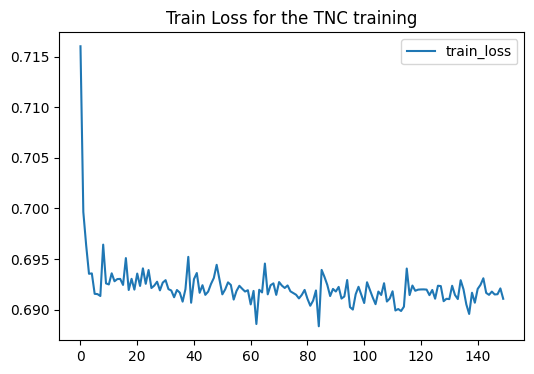

In [11]:
# Start training
trainer.fit(tnc_model, train_dataloader, validation_dataloader)
#torch.save(tnc_model.encoder.state_dict(), "./weights/tnc_encoder.pt")

In [ ]:
# # Checking if there are weights saved from previous training, else it trains from scratch
# try:
#     torch.load_state_dict(torch.load('./weights/tnc_encoder.pt'))
# except:
#     trainer = pl.Trainer(max_epochs=150, callbacks=EncoderPrintMetrics(), accelerator="gpu", devices=1)
#     trainer.fit(tnc_model, train_dataloader, validation_dataloader)
#     torch.save(tnc_model.encoder.state_dict(), "./weights/tnc_encoder.pt")
encoder.load_state_dict(torch.load('./weights/tnc_encoder.pt'))

<All keys matched successfully>

# TNC Fine-tunning

We are going to use the TNC model on the downstream task of classification. We will use same dataset and re-use the same encoder

In [17]:
from typing import Any, Optional

from torchmetrics.functional import accuracy


class StateClassifier(torch.nn.Module):
    def __init__(self, input_size: int = 10, n_classes: int = 6):
        super(StateClassifier, self).__init__()
        self.input_size = input_size
        self.n_classes = n_classes
        self.normalize = torch.nn.BatchNorm1d(self.input_size)
        self.nn = torch.nn.Linear(self.input_size, self.n_classes)
        torch.nn.init.xavier_uniform_(self.nn.weight)

    def forward(self, x):
        x = self.normalize(x)
        logits = self.nn(x)
        return logits
    
class TNC_Classifier(pl.LightningModule):
    def __init__(
        self,
        encoder: torch.nn.Module,
        classifier: torch.nn.Module,
        lr: float = 1e-1,
        weight_decay: float = 0.0,
        task_class: str = "multiclass",
        num_classes: int = 6
    ):
        super().__init__()
        self.encoder = encoder.to(self.device)
        self.classifier = classifier.to(self.device)
        self.learning_rate = lr
        self.weight_decay = weight_decay
        self.training_step_losses = []
        self.validation_step_losses = []
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.task_class = task_class
        self.num_classes = num_classes
        
        self.train_epoch_loss = []
        self.train_epoch_acc = []
        self.val_epoch_loss = []
        self.val_epoch_acc = []
        
    def configure_optimizers(self) -> Any:
        optimizer = torch.optim.Adam(
            self.classifier.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay
        )
        return optimizer
    
    def forward(self, x):
        encodings = self.encoder(x)
        predictions = self.classifier(encodings)
        return predictions
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self.forward(x)
        loss = self.loss_function(predictions, y.long())
        self.training_step_losses.append(loss)
        return loss
    
    def on_train_epoch_end(self) -> None:
        # do something with all training_step outputs, for example:
        epoch_mean = torch.stack(self.training_step_losses).mean()
        self.train_epoch_loss.append(epoch_mean.cpu().detach().numpy())
        self.log("train_loss", epoch_mean, on_epoch=True, on_step=False, prog_bar=True, logger=True)
        # free up the memory
        self.training_step_losses.clear()
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        self.validation_step_losses.append(loss)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log_dict(metrics)
        return metrics
    
    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"test_acc": acc, "test_loss": loss}
        self.log_dict(metrics)
        return metrics
        
    def on_validation_epoch_end(self) -> None:
        # do something with all training_step outputs, for example:
        epoch_mean = torch.stack(self.validation_step_losses).mean()
        self.val_epoch_loss.append(epoch_mean.cpu().detach().numpy())
        self.log("val_loss", epoch_mean, on_epoch=True, on_step=False, prog_bar=True, logger=True)
        # free up the memory
        self.validation_step_losses.clear()

    def _shared_eval_step(self, batch, batch_idx):
        x, y = batch
        predictions = self.forward(x)
        loss = self.loss_function(predictions, y.long())
        acc = accuracy(torch.argmax(predictions, dim=1), y.long(), task=self.task_class, num_classes=self.num_classes)
        return loss, acc
    
class ClassifierPrintMetrics(pl.Callback):
    def on_fit_end(self, trainer, pl_module):
        #train_acc = pl_module.train_acc.compute()
        #val_acc = pl_module.val_acc.compute()
        train_loss = pl_module.train_epoch_loss
        print(train_loss)
        val_loss = pl_module.val_epoch_loss
        
        print(f"\ntrain_loss={train_loss}, val_loss={val_loss}")
        
        # plotting train and val loss
        plt.figure(figsize=(6, 4))
        plt.plot(train_loss, label='train_loss')
        plt.plot(val_loss, label='val_loss')
        plt.legend()
        plt.title('Train and Validation Loss')
        plt.savefig('./plots/tnc_classifier_loss.png')
        
        # # plotting train and val acc
        # plt.figure(figsize=(12, 8))
        # plt.plot(train_loss, label='train_loss')
        # plt.plot(val_loss, label='val_loss')
        # plt.legend()
        # plt.title('Train and Validation Loss')
        # plt.savefig('./plots/tnc_classifier_loss.png')


In [18]:
data_path = Path('data/TNC/HAR_data')
x_train = np.load(data_path/'x_train.npy')
y_train = np.load(data_path/'y_train.npy')
x_test = np.load(data_path/'x_test.npy')
y_test = np.load(data_path/'y_test.npy')

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((21, 561, 281), (21, 281), (9, 561, 288), (9, 288))

In [19]:
class SimpleDataset:
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx].astype(np.float32), self.y[idx].astype(np.float32)
        else:
            return self.X[idx].astype(np.float32)
        
# train_dataset = SimpleDataset(x_train)
# test_dataset = SimpleDataset(x_test, y_test)
# len(train_dataset), len(test_dataset)

In [28]:

# This code as taken from the authors

def create_simulated_dataset(
    X_train, Y_train, X_test, Y_test, window_size=50, batch_size=100
):
    n_train = int(0.8 * len(X_train))
    n_valid = len(X_train) - n_train
    n_test = len(X_test)
    x_train, y_train = X_train[:n_train], Y_train[:n_train]
    x_valid, y_valid = X_train[n_train:], Y_train[n_train:]
    x_test, y_test = X_test, Y_test

    datasets = []
    for x, y, size in [
        (x_train, y_train, n_train),
        (x_test, y_test, n_test),
        (x_valid, y_valid, n_valid),
    ]:
        T = x.shape[-1]
        windows = np.split(
            x[:, :, : window_size * (T // window_size)], (T // window_size), -1
        )
        windows = np.concatenate(windows, 0)
        labels = np.split(
            y[:, : window_size * (T // window_size)], (T // window_size), -1
        )
        labels = np.round(np.mean(np.concatenate(labels, 0), -1))
        dset = SimpleDataset(windows, labels)
        datasets.append(dset)

    trainset, testset, validset = datasets[0], datasets[1], datasets[2]
    print(f'dataset sizes: train={len(trainset)}, test={len(testset)}, valid={len(validset)}')
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(validset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

    return train_loader, valid_loader, test_loader

train_loader, valid_loader, test_loader = create_simulated_dataset(x_train, y_train, x_test, y_test, window_size=4, batch_size=100)

dataset sizes: train=1120, test=648, valid=350


In [33]:
encoding_size = 10
n_classes = 6

classifier = StateClassifier(input_size=encoding_size, n_classes=n_classes)
tnc_classifier = TNC_Classifier(encoder, classifier, lr=1e-3)


In [38]:
trainer = pl.Trainer(max_epochs=600, callbacks=ClassifierPrintMetrics(), accelerator="gpu", devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type             | Params
---------------------------------------------------
0 | encoder       | GRUEncoder       | 399 K 
1 | classifier    | StateClassifier  | 86    
2 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
399 K     Trainable params
0         Non-trainable params
399 K     Total params
1.600     Total estimated model params size (MB)


Epoch 599: 100%|██████████| 12/12 [00:00<00:00, 51.03it/s, v_num=75, val_loss=0.606, train_loss=0.603] 

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 599: 100%|██████████| 12/12 [00:00<00:00, 37.95it/s, v_num=75, val_loss=0.606, train_loss=0.603]
[array(3.2661128, dtype=float32), array(3.0740037, dtype=float32), array(2.8792846, dtype=float32), array(2.7739315, dtype=float32), array(2.6075363, dtype=float32), array(2.4817343, dtype=float32), array(2.3600135, dtype=float32), array(2.2685199, dtype=float32), array(2.1313348, dtype=float32), array(2.05411, dtype=float32), array(1.984911, dtype=float32), array(1.9155624, dtype=float32), array(1.8355849, dtype=float32), array(1.7949457, dtype=float32), array(1.7369465, dtype=float32), array(1.6856607, dtype=float32), array(1.6491947, dtype=float32), array(1.5940784, dtype=float32), array(1.5570643, dtype=float32), array(1.5279994, dtype=float32), array(1.5147474, dtype=float32), array(1.4676083, dtype=float32), array(1.4413714, dtype=float32), array(1.4133549, dtype=float32), array(1.397723, dtype=float32), array(1.3606266, dtype=float32), array(1.3526111, dtype=float32), array(1.3

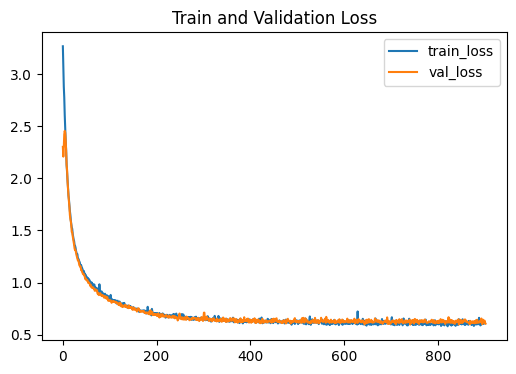

In [39]:
trainer.fit(tnc_classifier, train_dataloaders=train_loader, val_dataloaders=valid_loader)

## Classification evaluation

In [40]:
trainer.test(tnc_classifier, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 75.33it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7191358208656311     │
│         test_loss         │    0.6455227136611938     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.7191358208656311, 'test_loss': 0.6455227136611938}]

In [ ]:
classifier = StateClassifier(input_size=encoding_size, n_classes=n_classes)
tnc_classifier = TNC_Classifier(encoder, classifier)